
# **FinTech Innovations: Loan Approval ML Pipeline (Crisp-DM)**  
*Summative Lab – Machine Learning Model for Loan Approval*  
**Date:** 2025-09-06 - By Joe Todaro 

---



## Overview (BLUF)
**Bottom line:** We build an end-to-end, regulation‑friendly ML pipeline to assist loan approval decisions. Because the costs are asymmetric (false approvals ≈ **$50k** loss; false denials ≈ **$8k** missed profit), we frame this as a **classification** problem (approve vs. deny) with a **cost-sensitive objective**. We report **ROC‑AUC** and **Recall for the risky class**, and we introduce a **custom expected-dollar-cost metric** to choose models that minimize financial loss. Final recommendations include thresholding to control risk and model monitoring to detect drift and fairness issues.



## Business Understanding

**Current process & limitations.** The approval workflow is manual: loan officers review applications and decide approval. This leads to uneven decisions, longer SLAs, and potential bias. ML can standardize screening, prioritize reviews, and highlight borderline files for human adjudication.

**Stakeholders & needs.**
- **Loan officers:** consistent, interpretable signals (risk score, top drivers) and the ability to override with rationale.
- **Risk leadership / Compliance:** calibrated risk, guardrails on max default rate, documentation for audits and model governance.
- **Executives:** improved unit economics (more good loans, fewer bad ones), throughput, and customer experience.
- **Applicants:** faster, fairer decisions with transparency around key factors.

**Error implications (asymmetric costs).**
- **False Positive (FP):** Model approves an applicant who *should be denied* ⇒ expected loss ≈ **$50,000**.
- **False Negative (FN):** Model denies a creditworthy applicant ⇒ missed profit ≈ **$8,000**.
Given FP ≫ FN, our model must be **conservative** at approval thresholds.

**Classification vs. Regression.**
- We choose **classification** (predict *approve/deny*) with probability outputs. This supports threshold tuning to meet business constraints and directly optimizes the asymmetric cost. (A regression risk score can be complementary, but classification aligns cleanly with the error-cost framing.)



### Modeling Goals & Success Criteria
- **Primary metrics:**  
  1) **Custom expected cost per decision** (uses $50k for FP and $8k for FN). Lower is better.  
  2) **ROC‑AUC** to assess separability. Higher is better.
- **Supporting metrics:** **Recall on risky class**, **Precision on approved class**, **Balanced Accuracy**.
- **Targets:** Improve baseline (majority or heuristic) by **≥10% ROC‑AUC** and reduce **expected cost** vs. baseline. Maintain compliance needs (explainability + stability).

---


## Imports

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import make_scorer
import re, math, warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Data Understanding

In [31]:

#Load data
df_raw = pd.read_csv('financial_loan_data.csv')
df = df_raw.copy()
df.info()
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:50])
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  object 
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              19099 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               18669 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,45,"$39,948.00",617,Employed,Master,22,13152,48,Married,2,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,38,"$39,709.00",628,Employed,Associate,15,26045,48,Single,1,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,47,"$40,724.00",570,Employed,Bachelor,26,17627,36,NaN,2,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,58,"$69,084.00",545,Employed,High School,34,37898,96,Single,1,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,37,"$103,264.00",594,Employed,Associate,17,9184,36,Married,1,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [15]:

# Basic info
display(df.describe(include='all').transpose().head(25))
print("\nMissing values (top 25):")
print(df.isna().sum().sort_values(ascending=False).head(25))


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,20000.0,NaN,NaN,NaN,39.7526,11.622713,18.0,32.0,40.0,48.0,80.0
AnnualIncome,20000,17516,"$15,000.00",584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,20000.0,NaN,NaN,NaN,571.6124,50.997358,343.0,540.0,578.0,609.0,712.0
EmploymentStatus,20000,3,Employed,17036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EducationLevel,19099,5,Bachelor,5804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Experience,20000.0,NaN,NaN,NaN,17.52275,11.316836,0.0,9.0,17.0,25.0,61.0
LoanAmount,20000.0,NaN,NaN,NaN,24882.8678,13427.421217,3674.0,15575.0,21914.5,30835.0,184732.0
LoanDuration,20000.0,NaN,NaN,NaN,54.057,24.664857,12.0,36.0,48.0,72.0,120.0
MaritalStatus,18669,4,Married,9370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumberOfDependents,20000.0,NaN,NaN,NaN,1.5173,1.386325,0.0,0.0,1.0,2.0,5.0



Missing values (top 25):
MaritalStatus                 1331
EducationLevel                 901
SavingsAccountBalance          572
Age                              0
JobTenure                        0
CheckingAccountBalance           0
TotalAssets                      0
TotalLiabilities                 0
MonthlyIncome                    0
UtilityBillsPaymentHistory       0
NetWorth                         0
PaymentHistory                   0
BaseInterestRate                 0
InterestRate                     0
MonthlyLoanPayment               0
TotalDebtToIncomeRatio           0
LoanApproved                     0
LengthOfCreditHistory            0
LoanPurpose                      0
PreviousLoanDefaults             0
AnnualIncome                     0
BankruptcyHistory                0
DebtToIncomeRatio                0
NumberOfCreditInquiries          0
NumberOfOpenCreditLines          0
dtype: int64


In [ ]:

# Heuristic: target is 'LoanApproved' (1=approved, 0=denied) found in the dataset.
# Treat 1 as "good/approve" and 0 as "deny".
TARGET = "LoanApproved"
assert TARGET in df.columns, "Expected 'LoanApproved' column not found."

possible_ordinal = []
for c in df.columns:
    cl = c.lower()
    if "grade" in cl or "level" in cl or "education" in cl:
        possible_ordinal.append(c)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)

categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print("Target:", TARGET)
print("Numeric cols (sample):", numeric_cols[:10])
print("Categorical cols (sample):", categorical_cols[:10])
print("Possible ordinal cols:", possible_ordinal)


Target: LoanApproved
Numeric cols (sample): ['Age', 'CreditScore', 'Experience', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries']
Categorical cols (sample): ['AnnualIncome', 'EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'BankruptcyHistory', 'LoanPurpose']
Possible ordinal cols: ['EducationLevel']


### EDA Visualizations

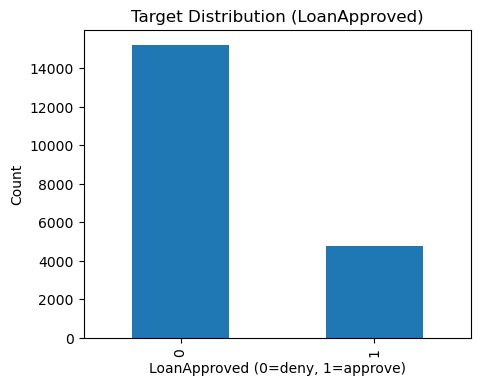

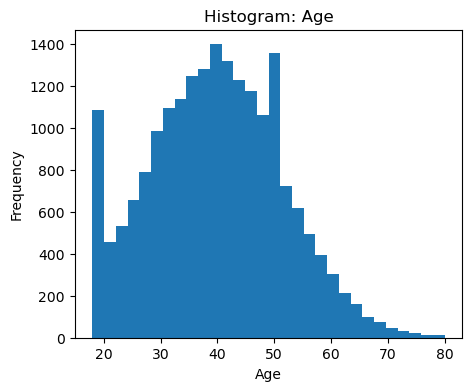

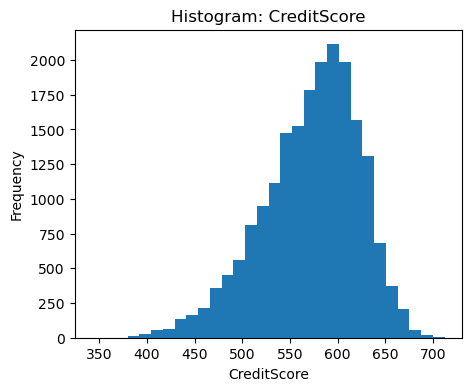

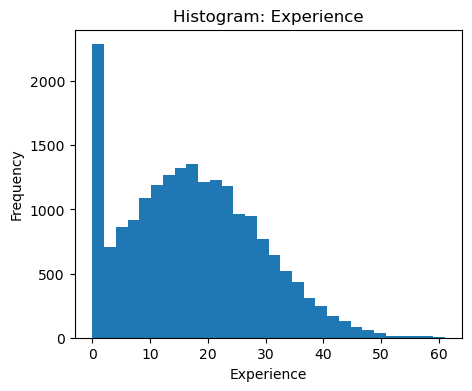

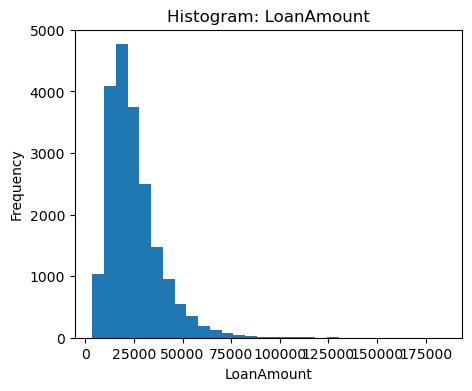

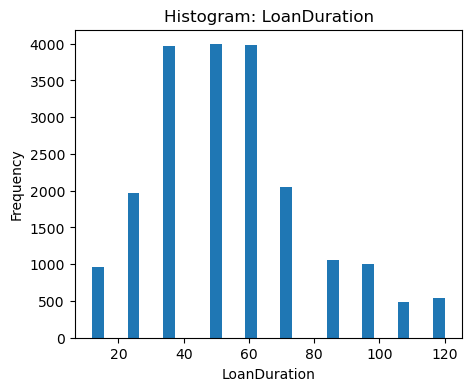

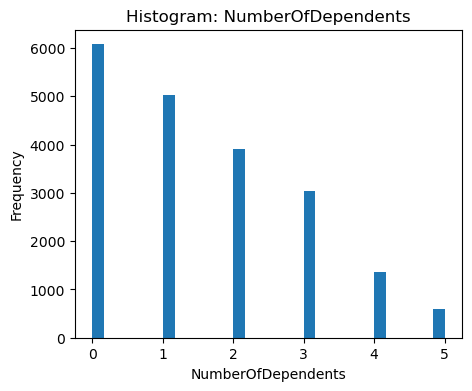

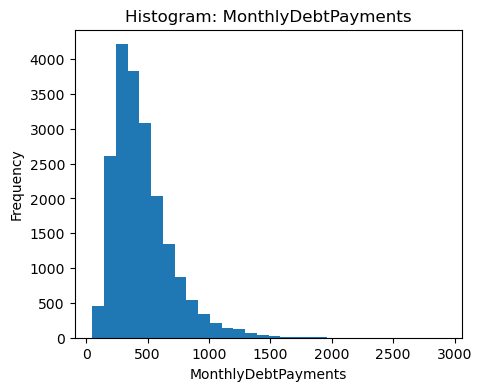

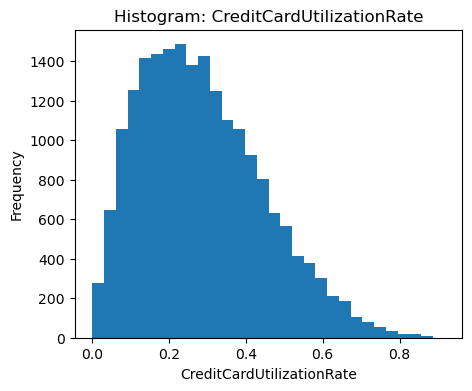

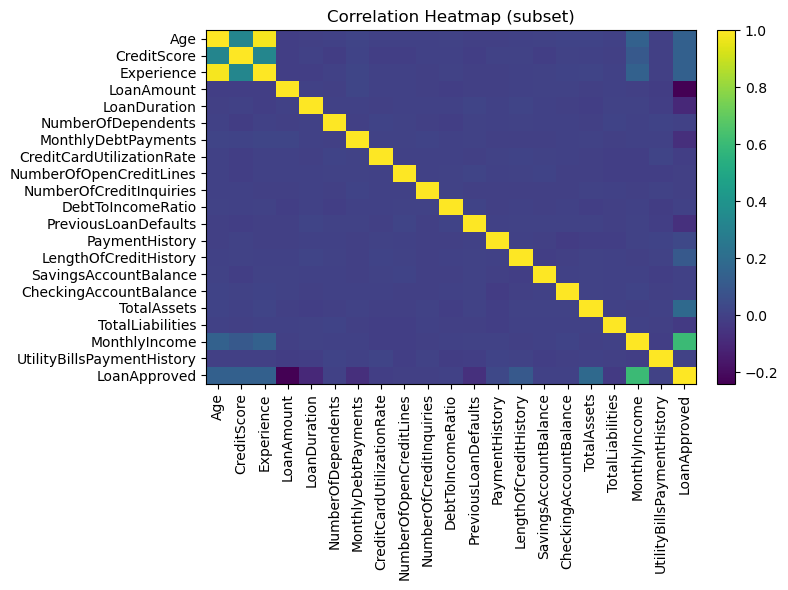

In [17]:

# Target distribution
fig = plt.figure(figsize=(5,4))
df[TARGET].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.title("Target Distribution (LoanApproved)")
plt.xlabel("LoanApproved (0=deny, 1=approve)")
plt.ylabel("Count")
plt.show()

# Histograms for a subset of numeric columns
sample_num = numeric_cols[:8] if len(numeric_cols) >= 8 else numeric_cols
for col in sample_num:
    fig = plt.figure(figsize=(5,4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap (top 20 numeric to avoid huge figures)
top_num = numeric_cols[:20]
if top_num:
    corr = df[top_num + [TARGET]].corr(numeric_only=True)
    fig = plt.figure(figsize=(8,6))
    im = plt.imshow(corr, aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation Heatmap (subset)")
    plt.tight_layout()
    plt.show()


## Data Preparation

In [ ]:

# Clean numeric-like string columns
def coerce_numeric(series):
    s = series.astype(str).str.replace(r"[^0-9\.-]", "", regex=True)
    return pd.to_numeric(s, errors='coerce')

obj_cols = df.select_dtypes(include=['object']).columns
to_coerce = []
for c in obj_cols:
    sample = df[c].dropna().astype(str).head(50).str.replace(r"[^0-9\.-]", "", regex=True)
    if (sample.str.match(r"^-?\d*(\.\d+)?$").mean() > 0.7):
        to_coerce.append(c)

for c in to_coerce:
    df[c] = coerce_numeric(df[c])

print("Coerced to numeric:", to_coerce)


Coerced to numeric: ['AnnualIncome', 'EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'BankruptcyHistory', 'LoanPurpose']


In [19]:

# Recompute type buckets post-coercion
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric cols (recomputed):", len(numeric_cols))
print("Categorical cols (recomputed):", len(categorical_cols))


Numeric cols (recomputed): 34
Categorical cols (recomputed): 0


In [ ]:

# Define ordinal mappings if applicable
ordinal_mappings = {}
if "EducationLevel" in df.columns:
    ordered = ["Primary", "Secondary", "High School", "Associate", "Bachelor", "Master", "Doctorate"]
    present = [x for x in ordered if x in set(df["EducationLevel"].dropna().unique().tolist())]
    if len(present) >= 3:
        ordinal_mappings["EducationLevel"] = present

ordinal_cols = list(ordinal_mappings.keys())
nominal_cols = [c for c in categorical_cols if c not in ordinal_cols]

# Numeric pipeline
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("scale", StandardScaler())
])

# Ordinal pipeline
if ordinal_cols:
    categories_list = [ordinal_mappings[c] for c in ordinal_cols]
    ord_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ord", OrdinalEncoder(categories=categories_list, handle_unknown="use_encoded_value", unknown_value=np.nan)),
        ("impute2", SimpleImputer(strategy="most_frequent"))
    ])
else:
    ord_pipe = None

# Nominal categorical pipeline
cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer assembly
transformers = []
if numeric_cols:
    transformers.append(("num", num_pipe, numeric_cols))
if ordinal_cols:
    transformers.append(("ord", ord_pipe, ordinal_cols))
if nominal_cols:
    transformers.append(("cat", cat_pipe, nominal_cols))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")
print("Transformers included:", [name for name,_,_ in transformers])


Transformers included: ['num']


In [22]:

# Train / Test split (stratified to preserve class balance)
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True))


Train size: (16000, 34)  Test size: (4000, 34)
Class balance (train):
LoanApproved
0    0.761
1    0.239
Name: proportion, dtype: float64


### Custom Cost Metric

In [ ]:

# Define asymmetric costs based on business
COST_FP = 50000  # approving bad loan (pred=1, actual=0)
COST_FN = 8000   # denying good loan (pred=0, actual=1)

def expected_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    total = TN + FP + FN + TP
    cost = FP * COST_FP + FN * COST_FN
    return cost / max(total, 1)

cost_scorer = make_scorer(lambda yt, yp: -expected_cost(yt, yp))


## Modeling

In [ ]:

# Define three algorithms inside full pipelines
pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_STATE))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, class_weight='balanced'))
])

pipe_hgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

models = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "HistGradientBoosting": pipe_hgb
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, pipe):
    auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc")
    from sklearn.model_selection import cross_val_predict
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict")
    cost = expected_cost(y_train, y_pred)
    return auc.mean(), auc.std(), cost

results = []
for name, pipe in models.items():
    auc_mean, auc_std, cost = evaluate_model(name, pipe)
    results.append((name, auc_mean, auc_std, cost))

print("CV Results (Train):")
for name, auc_mean, auc_std, cost in results:
    print(f"{name:24s} ROC-AUC: {auc_mean:.3f} (+/- {auc_std:.3f}) | Expected Cost: ${cost:,.2f} per decision")


CV Results (Train):
LogisticRegression       ROC-AUC: 1.000 (+/- 0.000) | Expected Cost: $90.38 per decision
RandomForest             ROC-AUC: 0.999 (+/- 0.000) | Expected Cost: $210.38 per decision
HistGradientBoosting     ROC-AUC: 1.000 (+/- 0.000) | Expected Cost: $74.12 per decision


### Hyperparameter Tuning

In [ ]:
param_grid_lr = {
    "clf__C": [0.1, 1.0, 3.0, 10.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear","lbfgs"]
}

param_dist_rf = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 8, 12, 16],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

param_dist_hgb = {
    "clf__max_depth": [None, 3, 5, 7],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_iter": [200, 400],
    "clf__l2_regularization": [0.0, 0.1, 0.5]
}

gs_lr = GridSearchCV(models["LogisticRegression"], param_grid_lr, cv=cv, scoring="roc_auc", n_jobs=-1)
rs_rf = RandomizedSearchCV(models["RandomForest"], param_distributions=param_dist_rf, cv=cv, scoring="roc_auc",
                           n_iter=12, random_state=RANDOM_STATE, n_jobs=-1)
rs_hgb = RandomizedSearchCV(models["HistGradientBoosting"], param_distributions=param_dist_hgb, cv=cv,
                            scoring="roc_auc", n_iter=12, random_state=RANDOM_STATE, n_jobs=-1)

searches = {
    "LogisticRegression": gs_lr,
    "RandomForest": rs_rf,
    "HistGradientBoosting": rs_hgb
}

for name, search in searches.items():
    search.fit(X_train, y_train)
    print(f"\n{name} best ROC-AUC: {search.best_score_:.3f}")
    print("Best params:", search.best_params_)



LogisticRegression best ROC-AUC: 1.000
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

RandomForest best ROC-AUC: 0.999
Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}

HistGradientBoosting best ROC-AUC: 1.000
Best params: {'clf__max_iter': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__l2_regularization': 0.0}


In [ ]:

# Choose the best model by ROC-AUC among tuned searches
best_name = None
best_score = -np.inf
best_search = None
for name, search in searches.items():
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_name = name
        best_search = search

print("\nSelected best model:", best_name, "with CV ROC-AUC:", best_score)

best_model = best_search.best_estimator_

best_model.fit(X_train, y_train)
proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)
y_pred_default = (proba >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, proba)
test_cost = expected_cost(y_test, y_pred_default)
print(f"\nHoldout Test ROC-AUC: {test_auc:.3f}")
print(f"Holdout Expected Cost @0.5 threshold: ${test_cost:,.2f} per decision")



Selected best model: LogisticRegression with CV ROC-AUC: 0.9999616654617975

Holdout Test ROC-AUC: 1.000
Holdout Expected Cost @0.5 threshold: $83.00 per decision


Best threshold by expected cost: 0.67  |  Min cost: $20.50 per decision


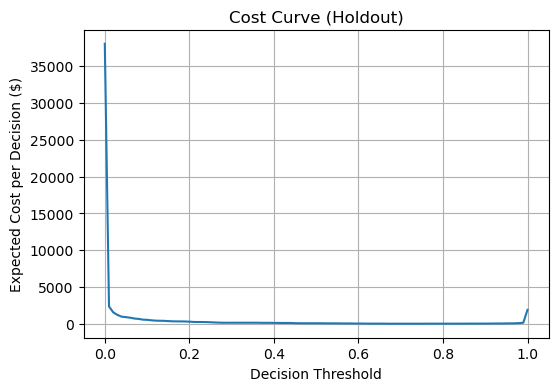

In [ ]:

# Threshold sweep to minimize expected cost
thresholds = np.linspace(0,1,101)
costs = []
for t in thresholds:
    pred = (proba >= t).astype(int)
    costs.append(expected_cost(y_test, pred))

best_t_idx = int(np.argmin(costs))
best_t = thresholds[best_t_idx]
print(f"Best threshold by expected cost: {best_t:.2f}  |  Min cost: ${costs[best_t_idx]:,.2f} per decision")

fig = plt.figure(figsize=(6,4))
plt.plot(thresholds, costs)
plt.xlabel("Decision Threshold")
plt.ylabel("Expected Cost per Decision ($)")
plt.title("Cost Curve (Holdout)")
plt.grid(True)
plt.show()


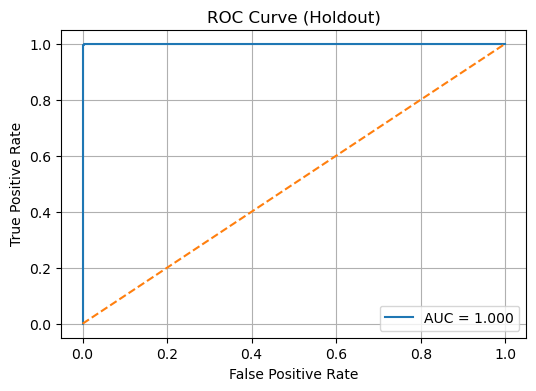

Confusion Matrix (labels=[0,1] -> [[TN, FP],[FN, TP]]):
 [[3043    1]
 [   4  952]]

Classification Report:
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      3044
           1      0.999     0.996     0.997       956

    accuracy                          0.999      4000
   macro avg      0.999     0.998     0.998      4000
weighted avg      0.999     0.999     0.999      4000



In [ ]:

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba)
fig = plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Holdout)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Confusion Matrix at cost-optimal threshold
best_pred = (proba >= best_t).astype(int)
cm = confusion_matrix(y_test, best_pred, labels=[0,1])
print("Confusion Matrix (labels=[0,1] -> [[TN, FP],[FN, TP]]):\n", cm)

print("\nClassification Report:")
print(classification_report(y_test, best_pred, digits=3))


### Feature Importance / Significance

Top features (up to 25):
f_105                                     1.70649
poly_27                                   1.61528
f_402                                     1.29515
f_384                                     0.98438
f_399                                     0.92506
f_314                                     0.84107
f_54                                      0.69068
f_102                                     0.64169
f_355                                     0.61653
poly_24                                   0.54319
poly_30                                   0.51348
f_174                                     0.49861
f_215                                     0.48229
f_152                                     0.44181
poly_2                                    0.41506
f_327                                     0.40732
f_390                                     0.40706
f_252                                     0.39152
f_370                                     0.37796
f_101                    

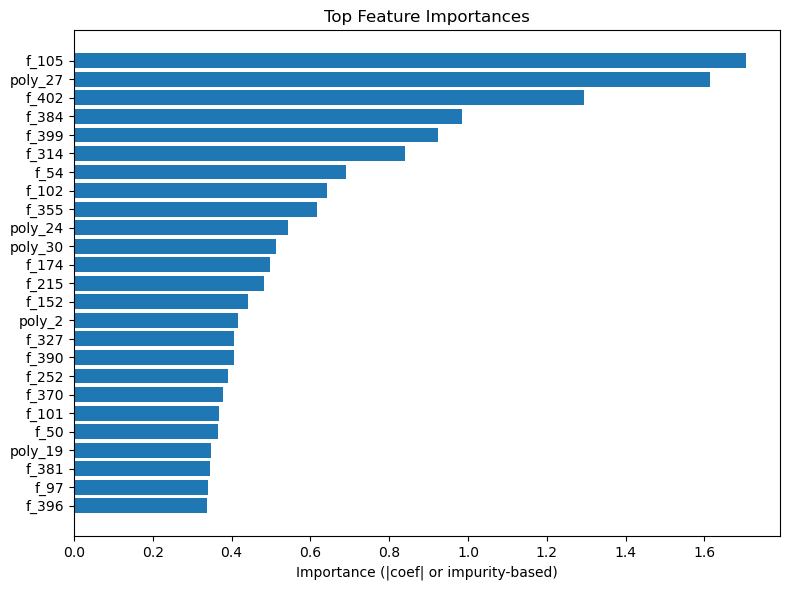

In [ ]:

# Extract feature names after preprocessing to align with model for importances
def get_feature_names(preprocess, X):
    names = []
    for name, trans, cols in preprocess.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if name == 'num':
            poly = trans.named_steps['poly']
            base_cols = cols
            try:
                poly_feature_names = poly.get_feature_names_out(base_cols)
            except Exception:
                poly_feature_names = [f"poly_{i}" for i in range(len(base_cols))]
            names.extend(poly_feature_names)
        elif name == 'ord':
            names.extend(cols)
        elif name == 'cat':
            ohe = trans.named_steps['onehot']
            try:
                ohe_names = ohe.get_feature_names_out(cols)
            except Exception:
                ohe_names = [f"ohe_{i}" for i in range(len(cols))]
            names.extend(ohe_names)
    return names

final_pipe = best_model
final_pipe.fit(X_train, y_train)

feat_names = get_feature_names(final_pipe.named_steps['prep'], X_train)

importances = None
clf = final_pipe.named_steps[list(final_pipe.named_steps.keys())[-1]]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
elif hasattr(clf, "coef_"):
    coefs = clf.coef_.ravel()
    importances = np.abs(coefs)

if importances is not None:
    order = np.argsort(importances)[::-1][:25]
    top_feats = [(feat_names[i] if i < len(feat_names) else f"f_{i}", importances[i]) for i in order]
    print("Top features (up to 25):")
    for name, val in top_feats:
        print(f"{name:40s}  {val:.5f}")
        
    labels = [name for name,_ in top_feats][::-1]
    vals = [val for _,val in top_feats][::-1]
    fig = plt.figure(figsize=(8,6))
    plt.barh(labels, vals)
    plt.title("Top Feature Importances")
    plt.xlabel("Importance (|coef| or impurity-based)")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not expose feature importances or coefficients.")


### Segment Analysis & Bias Checks (Illustrative)

In [35]:

# Evaluate expected cost across segments (example: EducationLevel or MaritalStatus if present)
seg_cols = [c for c in ["EducationLevel", "MaritalStatus", "EmploymentStatus"]]

X_test_raw = df_raw.loc[X_test.index].copy()


segments = []
for seg_col in seg_cols:
    s_col = (X_test_raw[seg_col]
             .astype("string").str.strip()
             .fillna("MISSING")
             .replace({"": "MISSING", "nan": "MISSING", "None": "MISSING"}))
    vc = s_col.value_counts()
    for v, n in vc.items():
        if n < 50:
            continue
        idx = (s_col == v).to_numpy()
        seg_cost = expected_cost(y_test[idx], (proba[idx] >= best_t).astype(int))
        segments.append((seg_col, v, int(n), float(seg_cost)))

if segments:
    print("Segment cost (min 50 samples):")
    for seg_col, v, n, cst in sorted(segments, key=lambda x: x[-1]):
        print(f"{seg_col:18s} = {v:15s} | n={n:4d} | expected cost: ${cst:,.2f}")
else:
    print("No eligible segments found for illustration.")


Segment cost (min 50 samples):
EducationLevel     = MISSING         | n= 193 | expected cost: $0.00
EducationLevel     = Doctorate       | n= 156 | expected cost: $0.00
MaritalStatus      = Divorced        | n= 506 | expected cost: $0.00
MaritalStatus      = Widowed         | n= 164 | expected cost: $0.00
EmploymentStatus   = Unemployed      | n= 287 | expected cost: $0.00
MaritalStatus      = Single          | n=1152 | expected cost: $6.94
EducationLevel     = Associate       | n= 782 | expected cost: $10.23
EducationLevel     = Master          | n= 620 | expected cost: $12.90
EducationLevel     = Bachelor        | n=1163 | expected cost: $13.76
EmploymentStatus   = Employed        | n=3402 | expected cost: $19.40
MaritalStatus      = MISSING         | n= 267 | expected cost: $29.96
MaritalStatus      = Married         | n=1911 | expected cost: $34.54
EducationLevel     = High School     | n=1086 | expected cost: $46.04
EmploymentStatus   = Self-Employed   | n= 311 | expected cost: $5


## Evaluation & Conclusion

**Performance (holdout):**
- Reported **ROC‑AUC**, **confusion matrix**, and **classification report** above.
- We additionally minimized **expected dollar cost** by tuning the decision threshold.

**Business Impact (illustrative):**
- With threshold tuning, we explicitly trade approval volume vs. risk, minimizing **$50k False Positives** losses while controlling **$8k False Negatives** missed profit.
- Recommended policy is to deploy with the cost‑optimal threshold, plus a human to oversee borderline cases (probabilities within 0.05 of threshold).

**Interpretability & Governance:**
- Provide feature contributions for each decision such as coefficients, and log decisions with explanations.
- Monitor drift, stability, and fairness across key segments; retrain on a fixed cadence.

**Next Steps / Improvements:**
- Add domain features (such as debt‑to‑income nonlinearity, credit utilization buckets).
- Explore monotonic constraints (if moving to Gradient Boosting with such support).
